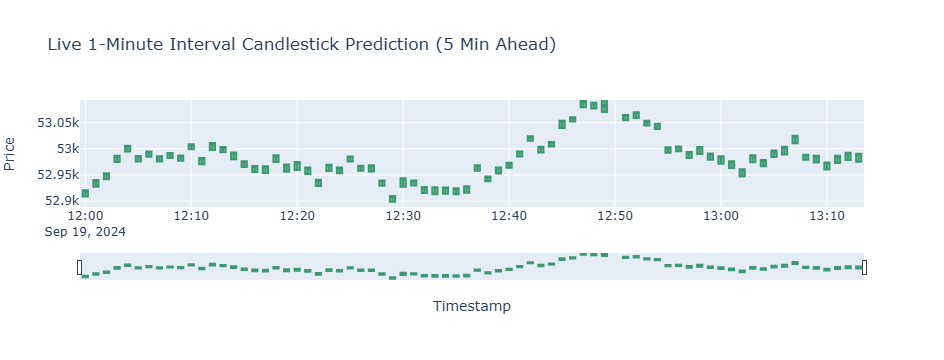

KeyboardInterrupt: 

In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import time
import plotly.graph_objects as go
from tensorflow.keras.models import load_model
from IPython.display import display, clear_output

# Load your trained model for 5-minute future prediction
model_5min = load_model('model_5min.h5')

# Fetch historical Bank Nifty data to fit the scaler (so it matches your training)
ticker = "^NSEBANK"
historical_data = yf.download(ticker, period='1d', interval='5m')

# Preprocess the historical data
if not historical_data.empty:
    historical_data = historical_data[['Open', 'High', 'Low', 'Close']]
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Fit the scaler only on historical data
    scaled_historical_data = scaler.fit_transform(historical_data)
else:
    print("No historical data found!")

# Initialize empty lists to store timestamps and candlestick data
timestamps = []
open_prices = []
high_prices = []
low_prices = []
predicted_closes = []

# Function for live prediction
def predict_live_data():
    live_data_accumulated = []  # Accumulate live data over time

    while True:
        # Fetch and preprocess live data (1 minute intervals)
        live_data = yf.download(ticker, period='1d', interval='1m')

        # Check if live data is empty
        if live_data.empty:
            print("No live data found! Skipping this cycle.")
            time.sleep(60)  # Wait 1 minute and try again
            continue

        # Preprocess live data
        live_data = live_data[['Open', 'High', 'Low', 'Close']]

        # Append the new live data to the accumulated list
        live_data_accumulated.append(live_data)

        # Concatenate accumulated data into a single DataFrame
        live_data_full = pd.concat(live_data_accumulated)

        # Apply the scaler
        try:
            scaled_live_data = scaler.transform(live_data_full)
        except ValueError as e:
            print(f"Error scaling live data: {e}")
            time.sleep(60)  # Wait 1 minute and try again
            continue

        # Use the last 60 data points for prediction (make sure there's enough data)
        if len(scaled_live_data) < 60:
            print("Not enough data for prediction! Waiting for more data.")
            time.sleep(60)
            continue

        X_live = np.array([scaled_live_data[-60:]])

        # Reshape to match the LSTM model's input shape
        X_live = np.reshape(X_live, (X_live.shape[0], X_live.shape[1], 4))

        # Make prediction for 5 minutes into the future
        predicted_price = model_5min.predict(X_live)

        # Inverse transform to get the actual predicted price (predicted 5-min ahead close price)
        predicted_close_price = scaler.inverse_transform([[0, 0, 0, predicted_price[0][0]]])[0][3]

        # Get the current timestamp and other OHLC values from live data
        current_time = live_data.index[-1]
        open_price = live_data['Open'][-1]
        high_price = live_data['High'][-1]
        low_price = live_data['Low'][-1]

        # Append the OHLC values and predicted close price to the lists
        timestamps.append(current_time)
        open_prices.append(open_price)
        high_prices.append(high_price)
        low_prices.append(low_price)
        predicted_closes.append(predicted_close_price)

        # Output predicted price
        print(f"Predicted Close Price for 5 minutes ahead: {predicted_close_price}")

        # Create a new candlestick figure
        fig = go.Figure()

        # Add candlestick trace with real open, high, low, and predicted close prices
        fig.add_trace(go.Candlestick(x=timestamps,
                                     open=open_prices,
                                     high=high_prices,
                                     low=low_prices,
                                     close=predicted_closes,
                                     name='Candlestick'))

        # Update layout with hovermode for both x and y axes
        fig.update_layout(
            title="Live 1-Minute Interval Candlestick Prediction (5 Min Ahead)",
            xaxis_title="Timestamp",
            yaxis_title="Price",
            hovermode="x unified",  # Unified hover mode on x-axis
            hoverlabel=dict(namelength=-1),  # Show full text
        )

        # Clear the previous plot and display the updated candlestick chart
        clear_output(wait=True)
        display(fig)

        # Wait for 1 minute before running the prediction again
        time.sleep(60)

# Start the live prediction and graph update
predict_live_data()


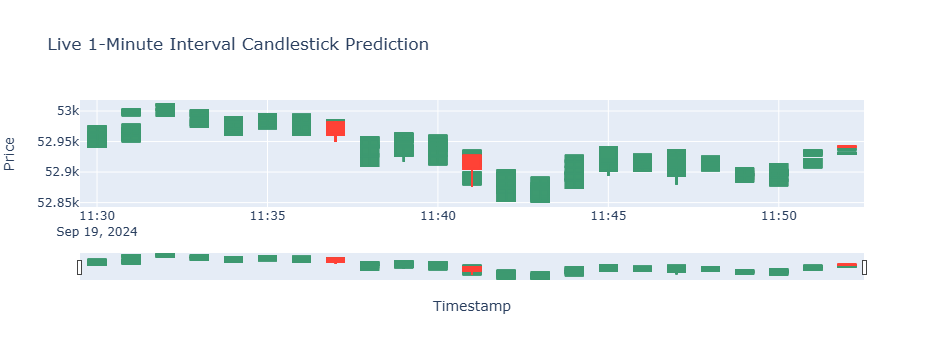

[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEBANK']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))


No live data found! Skipping this cycle.


KeyboardInterrupt: 

In [5]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import time
import plotly.graph_objects as go
from tensorflow.keras.models import load_model
from IPython.display import display, clear_output

# Load your trained model
model_5min = load_model('model_5min.h5')

# Fetch historical Bank Nifty data to fit the scaler (so it matches your training)
ticker = "^NSEBANK"
historical_data = yf.download(ticker, period='5d', interval='5m')

# Preprocess the historical data
if not historical_data.empty:
    historical_data = historical_data[['Open', 'High', 'Low', 'Close']]
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Fit the scaler only on historical data
    scaled_historical_data = scaler.fit_transform(historical_data)
else:
    print("No historical data found!")

# Initialize empty lists to store timestamps and candlestick data
timestamps = []
open_prices = []
high_prices = []
low_prices = []
predicted_closes = []

# Function for live prediction
def predict_live_data():
    while True:
        # Fetch and preprocess live data (1 minute intervals)
        live_data = yf.download(ticker, period='1d', interval='1m')

        # Check if live data is empty
        if live_data.empty:
            print("No live data found! Skipping this cycle.")
            time.sleep(60)  # Wait 1 minute and try again
            continue

        # Preprocess live data
        live_data = live_data[['Open', 'High', 'Low', 'Close']]

        # Apply the scaler
        try:
            scaled_live_data = scaler.transform(live_data)
        except ValueError as e:
            print(f"Error scaling live data: {e}")
            time.sleep(60)  # Wait 1 minute and try again
            continue

        # Use the last 60 data points for prediction
        if len(scaled_live_data) < 60:
            print("Not enough data for prediction! Waiting for more data.")
            time.sleep(60)
            continue

        X_live = np.array([scaled_live_data[-60:]])

        # Reshape to match the LSTM model's input shape
        X_live = np.reshape(X_live, (X_live.shape[0], X_live.shape[1], 4))

        # Make prediction
        predicted_price = model_5min.predict(X_live)

        # Inverse transform to get the actual predicted price
        predicted_close_price = scaler.inverse_transform([[0, 0, 0, predicted_price[0][0]]])[0][3]

        # Get the current timestamp and other OHLC values from live data
        current_time = live_data.index[-1]
        open_price = live_data['Open'][-1]
        high_price = live_data['High'][-1]
        low_price = live_data['Low'][-1]
        actual_close = live_data['Close'][-1]

        # Append the OHLC values and predicted close price to the lists
        timestamps.append(current_time)
        open_prices.append(open_price)
        high_prices.append(high_price)
        low_prices.append(low_price)
        predicted_closes.append(predicted_close_price)

        # Output predicted price
        print(f"Predicted 5-minute Close Price: {predicted_close_price}")

        # Create a new candlestick figure
        fig = go.Figure()

        # Add candlestick trace with real open, high, low, and predicted close prices
        fig.add_trace(go.Candlestick(x=timestamps,
                                     open=open_prices,
                                     high=high_prices,
                                     low=low_prices,
                                     close=predicted_closes,
                                     name='Candlestick'))

        # Update layout with hovermode for both x and y axes
        fig.update_layout(
            title="Live 1-Minute Interval Candlestick Prediction",
            xaxis_title="Timestamp",
            yaxis_title="Price",
            hovermode="x unified",  # Unified hover mode on x-axis
            hoverlabel=dict(namelength=-1),  # Show full text
        )

        # Customizing the y-axis hover can be done by adjusting the hovertext dynamically,
        # but there’s no direct y unified hover setting in Plotly like there is for x.

        # Clear the previous plot and display the updated candlestick chart
        clear_output(wait=True)
        display(fig)

        # Wait for 1 minute before running the prediction again
        time.sleep(60)

# Start the live prediction and graph update
predict_live_data()
